In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
import shutil
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from pathlib import Path

import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings(action='ignore')

random.seed(42)
np.random.seed(42)
tf.random.set_seed(1)

from utils import *
from models import CNN_Encoder, RNN_Decoder

In [2]:
## debug
# True : 데이터 셋의 일부만 사용
# False : 모두 사용(주의, 오래걸림)
debug = True
# 학습시 사용할 최대 단어 토큰의 갯수 설정
top_k = 10000
# train / validation set 비율
ratio = 0.8

## set path
p_cwd = Path('.')
ROOTPATH = p_cwd.cwd()
train_annotation_file = ROOTPATH / 'annotations' / 'captions_train2017.json'
test_annotation_file = ROOTPATH / 'annotations' / 'captions_val2017.json'
train_PATH = ROOTPATH / 'train2017'


# COCO dataset 
# annotation, train2017 folder를 만들고, 데이터를 받습니다.
download_cocodataset()

In [3]:
## prepare data sets

# annotation 로드
with open(train_annotation_file, 'r') as f:
    annotations = json.load(f)

# image_path_to_caption -> dict, key: image_path, value: cation
# image_paths -> image path list
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  image_path = f"{str(train_PATH)}/{val['image_id']:012}.jpg"
  caption = f"<start> {val['caption']} <end>"

  image_path_to_caption[image_path].append(caption)

  image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

if debug: # True, 6000개 이미지만 사용
  train_image_paths = image_paths[:6000]
  print(len(train_image_paths))
else :
  train_image_paths = image_paths
  print(len(train_image_paths))

# 1개 이미지, 5~7 caption
# flat list로 변경해줍니다.
train_captions, img_name_vector = caption_and_img_vector(train_image_paths, image_path_to_caption)

6000


In [4]:
## image feature extraction
# (299,299,3) 이미지를 pretrained model인 inceptionV3를 사용, (8,8,2048) 텐서로 특징 추출
# gpu 설정을 확인하세요

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

batch_inceptionV3 = 32
encode_train = sorted(set(img_name_vector))

# 데이터 파이프라인을 만들어 줍니다.
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
                load_image, 
                num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_inceptionV3)

for img, path in tqdm(image_dataset): 
  # feature = (8,8,2048)
  batch_features = image_features_extract_model(img) 
  # (8,8,2048) -> (64,2048)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) 
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8") 
    # feature를 numpy file로 직접 저장합니다
    np.save(path_of_feature, bf.numpy())

In [5]:
## caption tokenizer
# caption 데이터를 token으로 변경합니다.

print(f'number of vocaps: {top_k}')
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# 학습된 토크나이저가 문장 리스트를 seqs형태로 저장
tokenizer.fit_on_texts(train_captions) 
train_seqs = tokenizer.texts_to_sequences(train_captions) 

#문장의 길이를 맞추는 PAD를 idx 0에 저장
tokenizer.word_index['<pad>'] = 0 
tokenizer.index_word[0] = '<pad>'
tokenizer.index_word

train_seqs = tokenizer.texts_to_sequences(train_captions)  
max_length = calc_max_length(train_seqs) 

# 각 벡터를 캡션의 max_length까지 padding
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') 


number of vocaps: 10000


In [6]:
# train, validation set split

(img_name_train, cap_train, 
 img_name_val, cap_val, img_to_cap_vector) = train_test_splits(img_name_vector, cap_vector, ratio=ratio)


24019 24019 6002 6002


In [19]:
## 학습과 평가를 위한 함수
# train step
@tf.function
def train_step(img_tensor, target): 
  # img_tensor 64x2048 feature map, target은 토큰화된 문장 벡터
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  # (배치크기 X 512)짜리 매트릭스로 0할당 초기화(처음 hidden state)
  hidden = decoder.reset_state(batch_size=target.shape[0]) 

  # <start>토큰을 배치사이즈만큼 준비, 첫번째 decode input
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) 

  with tf.GradientTape() as tape:
      # featuer input (b, 64, 2048) -> (b, 64, 256)
      features = encoder(img_tensor)
      
      # max length 토큰 만큼 반복(max length로 pad되어있기 때문에)
      for i in range(1, target.shape[1]): 
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, # 1번째 dec_input은 <start> 토큰
                                           features, # (b, 64, 256) # inception 통과한것을 fc로 축소한 feature
                                           hidden) # 
          
          # loss function -> predictions단어와 target단어를 비교해서 계산 target은 0이아닌 1부터(<start>토큰 다음)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          # training이니까 일단 prediction에서 정답이 나왔다고(첫 번째 단어 출력을 가정하고, 다음단어 예측하도록)
          dec_input = tf.expand_dims(target[:, i], 1)

  # full로 단어를 다 돌았을 때 평균계산
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


# validataion step
def loss_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss


# print caption & evaluate score
def evaluate(image): 

  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0) #image 로드 (299,299,3)
  img_tensor_val = image_features_extract_model(temp_input)

  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) 

  features = encoder(img_tensor_val)  # Inception_V3로 추출된 특징값을 encode
  # 첫 번째 decode input <start> 토큰
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) 
  result = []

  # max_length까지 decoder에 연속적으로 투입
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
    #관심을 가져야되는 항목을 추출하는곳 #그래프로 출력
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() 

    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
    result.append(tokenizer.index_word[predicted_id]) 

    if tokenizer.index_word[predicted_id] == '<end>': #만약 관심구역에서 나온 단어가 end라면
        return result, attention_plot #문장과 플롯을 반환
    # <end>토큰이 아니면  predicted_id 다음으로 넘겨서 문장의 길이가 최대를 넘지않을때까지 진행
    dec_input = tf.expand_dims([predicted_id], 0) 

  attention_plot = attention_plot[:len(result), :]
  
  return result, attention_plot


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


# captions on the validation set
def display_attention_caption(rid): # 비교를 위해 고정
  # rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i]
                          for i in cap_val[rid] if i not in [0]][1:])
  result, attention_plot = evaluate(image)

  print('Real Caption:', real_caption)
  print('Pred Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)


def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(13, 13))

  len_result = len(result)
  for i in range(len_result):
      temp_att = np.resize(attention_plot[i], (8, 8))
      grid_size = max(np.ceil(len_result/2), 2)
      ax = fig.add_subplot(grid_size, grid_size, i+1)
      ax.set_title(result[i])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      img = ax.imshow(temp_image)
      ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

In [8]:
# 평가 지표를 위한 함수들 

def l1_normalize(v): #각 벡터안의 요소값을 모두 더한 것의 크기가 1이 되도록 벡터의 크기를 조절하는 방법
    norm = np.sum(v)
    return v / norm


def score_fuction(img_name_val):
  gram_1 = []
  gram_2 = []
  gram_3 = []
  gram_4 = []
  gram_cum1 = []
  smoothie = SmoothingFunction().method5

  cosin_list=[]

  for j in tqdm(range(len(img_name_val))):
  # for j in tqdm(range(20)):

    image = img_name_val[j]

    # <pad> index 0을 제외, <start><end>토큰도 제외한 정답문장 토큰
    # img_to_cap_vector -> img와 caption이 매핑 
    ref = []
    for doc in img_to_cap_vector[image]:
      tokens = []
      for token in doc:
        if token not in [0,3,4]:
          tokens.append(tokenizer.index_word[token])
      ref.append(tokens) # 1개의 이미지에 5~7개의 caption이 붙어 있음

    candidate, _ = evaluate(image)
    # end 토큰제거, 출력문장
    candidate = candidate[:-1]

    ## blue score 
    bleu_1gram = sentence_bleu(ref,candidate, weights=(1, 0, 0, 0))
    bleu_2gram = sentence_bleu(ref,candidate, weights=(0, 1, 0, 0),smoothing_function=smoothie)
    bleu_3gram = sentence_bleu(ref,candidate, weights=(0, 0, 1, 0),smoothing_function=smoothie)
    bleu_4gram = sentence_bleu(ref,candidate, weights=(0, 0, 0, 1),smoothing_function=smoothie)
    bleu_cum1 = sentence_bleu(ref, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

    gram_1.append(bleu_1gram)
    gram_2.append(bleu_2gram)
    gram_3.append(bleu_3gram)
    gram_4.append(bleu_4gram)
    gram_cum1.append(bleu_cum1)

    # 생성문장을 마지막에 더함
    ref.append(candidate[:-1])
    doc_line = [' '.join(doc) for doc in ref]
    # tidf table만들고, 코사인 유사도 계산
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(doc_line)
    tfidf_norm_l1 = l1_normalize(tfidf_matrix) # L1 정규화  
    distance_matrix  = cosine_similarity(tfidf_norm_l1.todense())
    # 마지막 문장이 생성된 문장
    cosin = np.mean(distance_matrix[-1])
    cosin_list.append(cosin)

  blue_score = [ np.mean(gram_1),
              np.mean(gram_2),
              np.mean(gram_3),
              np.mean(gram_4),
              np.mean(gram_cum1) ]

  cosin_score = np.mean(cosin_list)

  return blue_score, cosin_score

In [9]:
## 학습 모델관련 hyperparameter 설정
BATCH_SIZE = 64
BUFFER_SIZE = 5000 #고정된 버퍼를 사용하여 항목이 통과할때 순서를 섞는다.
embedding_dim = 256 #임베딩 차원
units = 512 #노드 개수는 512개
vocab_size = top_k + 1 # max 사전크기 +1 개(<pad>)
num_steps = len(img_name_train) // BATCH_SIZE # length // batch 만큼의 스탭을 반복하여 1epoch의 학습을 진행함
v_num_steps = len(img_name_val) // BATCH_SIZE

# epochs
EPOCHS = 15

#InceptionV3에서 추출한 벡터의 모양은 (64, 2048)
features_shape = 2048 #특징 크기
attention_features_shape = 64


In [10]:
# dataset pipeline 구성
dataset, v_dataset = dataset_pipeline(img_name_train, cap_train, img_name_val, cap_val, 
                                      BUFFER_SIZE, BATCH_SIZE)


In [11]:
# encoder, decoder instance
encoder = CNN_Encoder(embedding_dim) #256 임베딩
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# optimizer set
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [12]:
## 체크포인트
checkpoint_path = "./checkpoints/final_model1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [13]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
v_loss_plot = []
blue_score_plot = []
cosin_score_plot = []

Train_loss
Epoch 1 Batch 0 Loss 0.4000
Epoch 1 Batch 100 Loss 0.4345
Epoch 1 Batch 200 Loss 0.4260
Epoch 1 Batch 300 Loss 0.3976
Epoch 1 Loss 0.439291
Time taken for 1 epoch 115.35 sec

Validation loss
Epoch 1 Batch 0 Loss 1.9650
Epoch 1 Loss 0.920704
Time taken for 1 epoch 66.28 sec

Train_loss
Epoch 2 Batch 0 Loss 0.4265
Epoch 2 Batch 100 Loss 0.4418
Epoch 2 Batch 200 Loss 0.3824
Epoch 2 Batch 300 Loss 0.3820
Epoch 2 Loss 0.416209
Time taken for 1 epoch 52.08 sec

Validation loss
Epoch 2 Batch 0 Loss 1.7677
Epoch 2 Loss 0.905994
Time taken for 1 epoch 63.82 sec

Train_loss
Epoch 3 Batch 0 Loss 0.3960
Epoch 3 Batch 100 Loss 0.4083
Epoch 3 Batch 200 Loss 0.3802
Epoch 3 Batch 300 Loss 0.4314
Epoch 3 Loss 0.394537
Time taken for 1 epoch 51.90 sec

Validation loss
Epoch 3 Batch 0 Loss 2.1447
Epoch 3 Loss 0.884878
Time taken for 1 epoch 64.08 sec

Real Caption: a plate of food with dumplings and rice and broccoli <end>
Pred Caption: a plate topped with steak and broccoli <end>


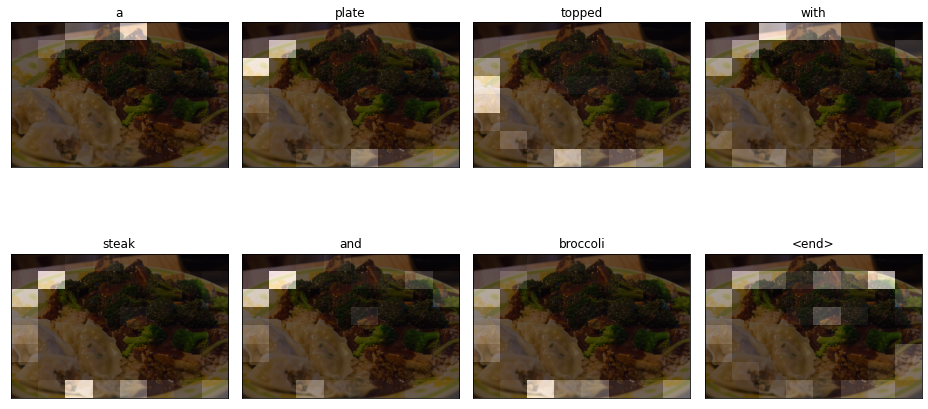


Time taken for eval 1432.63 sec

Train_loss
Epoch 4 Batch 0 Loss 0.3835
Epoch 4 Batch 100 Loss 0.3347
Epoch 4 Batch 200 Loss 0.3594
Epoch 4 Batch 300 Loss 0.3701
Epoch 4 Loss 0.373860
Time taken for 1 epoch 51.56 sec

Validation loss
Epoch 4 Batch 0 Loss 2.0183
Epoch 4 Loss 0.871670
Time taken for 1 epoch 63.06 sec

Train_loss
Epoch 5 Batch 0 Loss 0.3789
Epoch 5 Batch 100 Loss 0.3529
Epoch 5 Batch 200 Loss 0.3745
Epoch 5 Batch 300 Loss 0.3624
Epoch 5 Loss 0.355427
Time taken for 1 epoch 51.59 sec

Validation loss
Epoch 5 Batch 0 Loss 2.0044
Epoch 5 Loss 0.870619
Time taken for 1 epoch 63.53 sec

Real Caption: a plate of food with dumplings and rice and broccoli <end>
Pred Caption: some broccoli and broccoli <end>


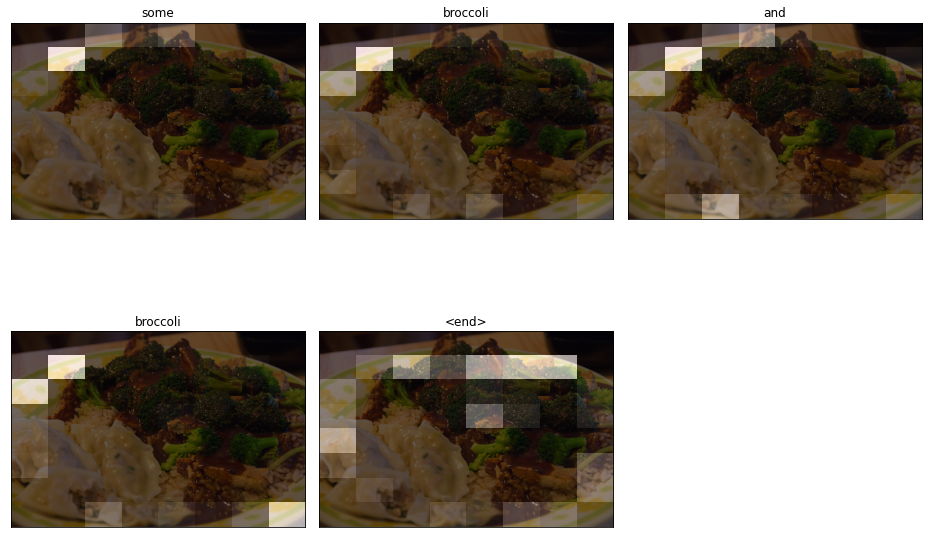


Time taken for eval 1460.42 sec



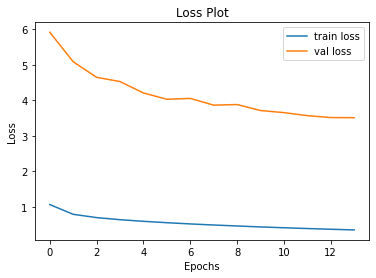

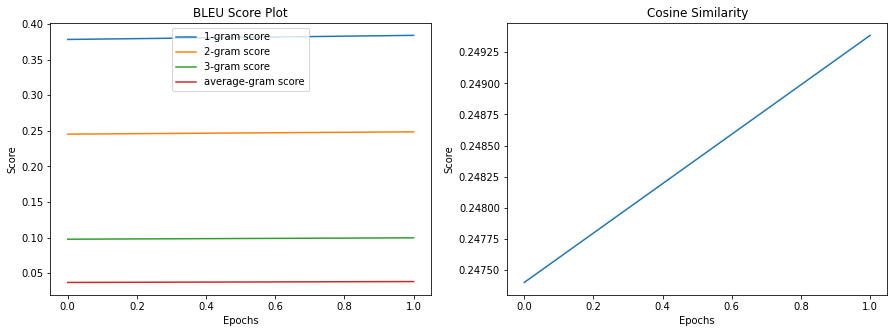

In [20]:
# 학습 진행
for epoch in range(start_epoch, EPOCHS):
    start_train = time.time()
    total_loss = 0

    print("Train_loss")
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start_train:.2f} sec\n')


    ## validation 
    start_validation = time.time()
    print("Validation loss")
    for (batch, (img_tensor, target)) in enumerate(v_dataset):
        batch_loss, t_loss = loss_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
          average_batch_loss = batch_loss.numpy()/int(target.shape[1])
          print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    v_loss_plot.append(float(total_loss / v_num_steps))

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start_validation:.2f} sec\n')


    # 2 epoch마다 checkpoint 저장 
    if (epoch % 2 == 0) and (epoch !=0):
      ckpt_manager.save()

      # local drive에 저장
      # copy_checkpoint_local()

      # 확인용 결과 출력
      display_attention_caption(rid=50)

      # 평가 지표 계산
      start_eval = time.time()
      blue_score, cosin_score = score_fuction(img_name_val)
      blue_score_plot.append(blue_score)
      cosin_score_plot.append(cosin_score)

      print(f'Time taken for eval {time.time()-start_eval:.2f} sec\n')


learing_curve(loss_plot, v_loss_plot)
blue_cos_score(blue_score_plot, cosin_score_plot)

In [21]:
loss_plot

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0683241>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7942004>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7016644>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6429565>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5973973>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.55837655>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52384025>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49345383>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.46599594>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.43929148>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4162092>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.39453727>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.37385958>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35542673>]